# Topic modeling 

## Description 
The ultimate goal of topic modeling is to find various topics that are present in your corpus. Each document in the corpus will be made up of at least one topic, if not multiple topics.
In this notebook, we will be covering the steps on how to do **Latent Dirichlet Allocation (LDA)**, which is one of many topic modeling techniques. It was specifically designed for text data.
To use a topic modeling technique, you need to provide (1) a document-term matrix and (2) the number of topics you would like the algorithm to pick up.
Once the topic modeling technique is applied, your job as a human is to interpret the results and see if the mix of words in each topic make sense.
If they don't make sense, you can try changing up the number of topics, the terms in the document-term matrix, model parameters, or even try a different model.

Data set comprises of 20 Newsgroups and using LDA to extract the naturally discussed topics.

Using Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

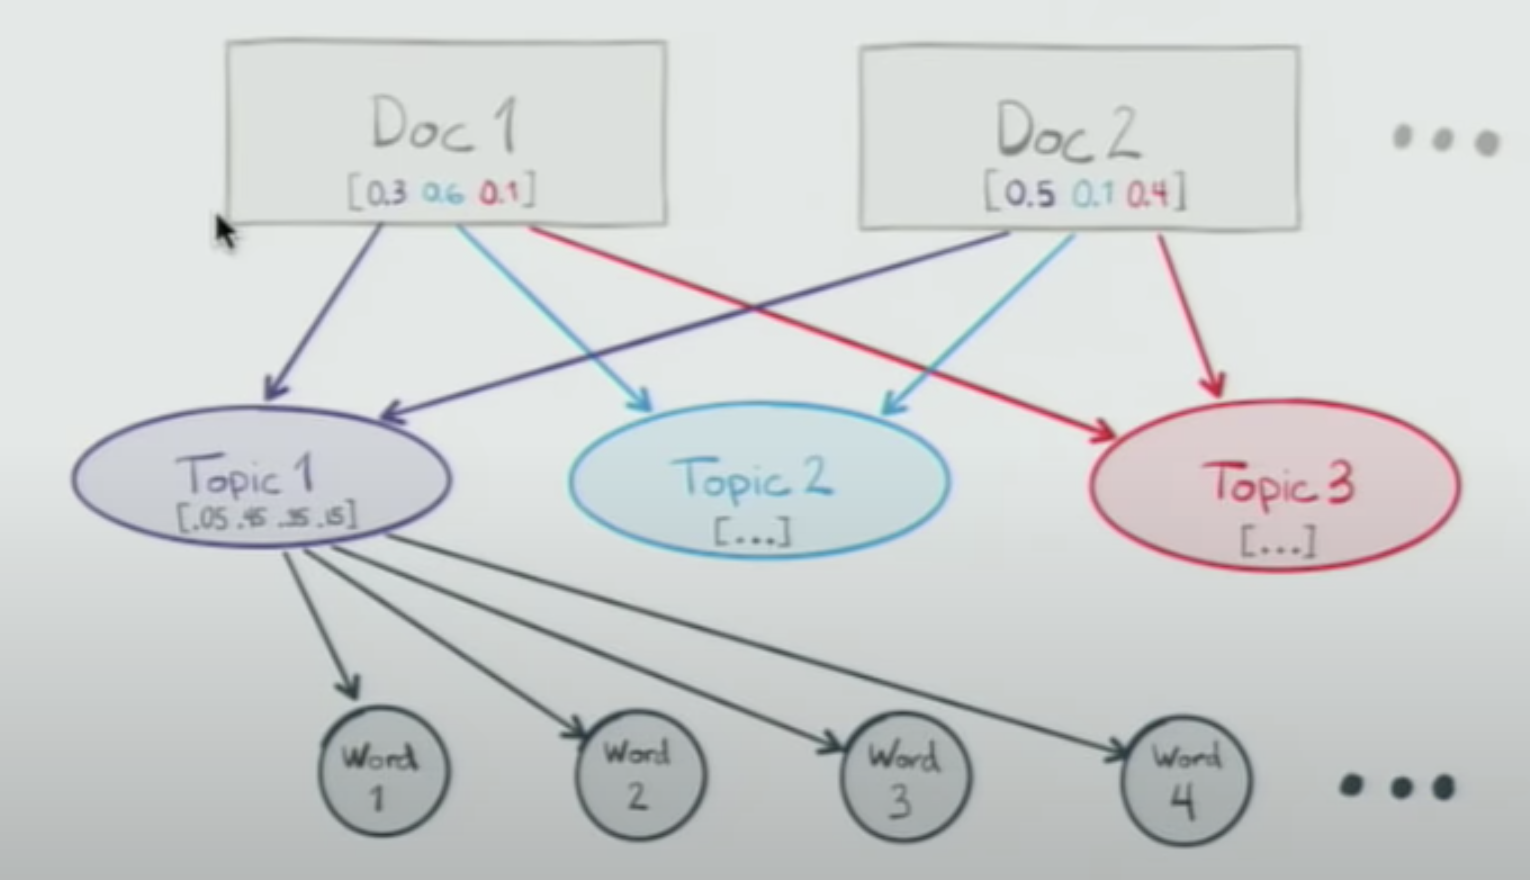

In [ ]:
# Run in python console
import nltk
nltk.download('stopwords')

In [ ]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [ ]:
import os
os.getcwd()

In [ ]:
!mkdir topic_modeling

In [ ]:
os.listdir()
os.chdir('./topic_modeling')

In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Import Data set

In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

## Remove mail ids and new line characters 

In [ ]:
# Convert to list
data = df.content.values.tolist()

In [ ]:
# Remove Emails
## \S*@\S*\s? removes email id with 0 or more non whitespace characters before @ followed by 0 or more non whitespace 
## characters followed by o or 1 whitespace characters 
## P.S : depracated '/' instead use r'...

import re
data = [re.sub(r'S*@S*s?', '', sent) for sent in data]
 
# Remove new line characters
## \s+ removes atleast 1 whitespace character 

data = [re.sub(r's+', ' ', sent) for sent in data]

# Remove distracting single quotes
## \' escapes single quotes 

data = [re.sub("\'", "", sent) for sent in data]

In [ ]:
pprint(data[:1])

## Gensim library for cleaning the data and tokenizing it , simple_preprocess

In [ ]:
## removing puntuation and other characters and than tokenizing it 
##len(data)
## deacc=True will remove all the punctuations 

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
## store the list of tokenized words in the list data_words
data_words = list(sent_to_words(data))

##print(data_words[:1])

In [ ]:
data_words[0]

## Bigrams & Trigrams

In [ ]:
## bigrams are phrases with 2 consecutive words implying a meaning and 
## trigrams are 3 consecutive words implying a certain meaning
## Gensim Phrases submodule can be used to implement bigrams and trigrams 

## parameters like min_count & threshold controls the complexity in making the bigrams, 
## higher it is harder to find the words 
# Build the bigram and trigram models

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) 

In [ ]:
bigram ## <gensim.models.phrases.Phrases at 0x1a3258e6a0>

In [ ]:
## Get the sentences 

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
display(print(bigram_mod[data_words[0]]))
display(print(trigram_mod[bigram_mod[data_words[0]]]))

## Removal of stop words 

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
data_words_nostops = remove_stopwords(data_words)

## Bigrams and trigrams 

In [ ]:
def bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
data_words_bigrams=bigrams(data_words_nostops)

In [ ]:
data_words_trigrams=trigrams(data_words_bigrams)

In [ ]:
len(data_words_trigrams)

In [ ]:
data_words_trigrams[0]

## Lemmatization 
We will be using spacy library to do the lemmetization as it is fast

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) ## helps in prepraring a doc
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en ## for installing 'english' model of spacy 
nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatize=lemmatization(data_words_bigrams,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
display(data_words_bigrams[0])
display(nlp(" ".join(data_words_bigrams[0])))

## LDA model of gensim library 

In [ ]:
## lda model takes 2 inputs : dictionary with unique id and corresponding to the words 
## and word id with the word frequency in corpus 

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatize)
## id2word containd words id and word for each word 

## create corpus 
texts = data_lemmatize

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
## corpus has list of tuples with word id with their frequency in that doc


In [ ]:
display(corpus[0])
display(id2word[0])

In [ ]:
## list of list of words and their freq in corpus 0 
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## Build the model 

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
## The model output is topic keys with certain weightage assigned to it
## this set has 20 topics with relevant words : manually name it 
lda_model.print_topics()

In [ ]:
doc_lda = lda_model[corpus]

In [ ]:
doc_lda

In [ ]:
## output of lda model is tuple with topic number and probability , each word in doc with the probable topic no
print(corpus[0])
print(doc_lda[0][:1])

In [120]:
## Model perplexity and coherence score 
## check the performance of the model

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatize, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.708143818152607

Coherence Score:  0.4078200495268362


## Visualize using pyLDAvis

In [103]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.348967 -0.035772       1        1  42.689472
15    -0.304604  0.058836       2        1  16.098503
0     -0.236948 -0.252462       3        1   9.033354
2     -0.217723  0.249305       4        1   7.955278
12    -0.119176  0.130315       5        1   4.236621
7     -0.065597 -0.251927       6        1   2.820626
14     0.025916  0.034087       7        1   2.439764
6      0.045407  0.002051       8        1   2.016899
10     0.061592  0.007099       9        1   1.768341
1      0.026980  0.099181      10        1   1.617640
4      0.006503  0.013898      11        1   1.537537
19     0.088311 -0.056719      12        1   1.295808
8      0.095869  0.011003      13        1   1.277867
13     0.130298  0.000373      14        1   0.948782
17     0.086945  0.003528      15        1   0.899154
18     0.124686  0.003428      16        1   0.888631
11     0.119533 -0.014820      17        1   0.840508
16     0.142466  0.001396      18        1   0.758496
3      0.149334  0.000112      19        1   0.693149
5      0.189175 -0.002913      20        1   0.183571, topic_info=     Category          Freq     Term         Total  loglift  logprob
14    Default  14567.000000     line  14567.000000  30.0000  30.0000
119   Default   7697.000000   people   7697.000000  29.0000  29.0000
89    Default   6665.000000       go   6665.000000  28.0000  28.0000
151   Default  16341.000000    would  16341.000000  27.0000  27.0000
210   Default   3035.000000  believe   3035.000000  26.0000  26.0000
...       ...           ...      ...           ...      ...      ...
7202  Topic20      0.035925  license      1.239415   2.7594 -10.7937
1644  Topic20      0.035925  section      1.239419   2.7594 -10.7937
3713  Topic20      0.035925  firearm      1.239435   2.7593 -10.7937
1155  Topic20      0.035925    shall      1.239411   2.7594 -10.7937
2754  Topic20      0.035925    apply      1.239466   2.7593 -10.7937

[817 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
65        4  0.998355          acce
732      17  0.955211  acceleration
1040      1  0.947961        accept
1040     15  0.050157        accept
733      17  0.995674      accident
...     ...       ...           ...
32        2  0.298467          year
32        3  0.463255          year
32       11  0.102568          year
872      17  0.992714      year_ago
488       3  0.997980         young

[940 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 16, 1, 3, 13, 8, 15, 7, 11, 2, 5, 20, 9, 14, 18, 19, 12, 17, 4, 6])

# LDA Mallet model

Mallet model of LDA is stronger version of normal LDA model which is improvement over it.

In [106]:
os.getcwd()

'/Users/ankitpatel/Downloads/nlp-in-python-tutorial-master/topic_modeling'

In [107]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
## set the path to the directory of mallet file
mallet_path = '/Users/ankitpatel/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
## params num_topics =-1 is set to -1 to get all the 20 topics 
pprint(ldamallet.show_topics(num_topics=-1,formatted=False))

In [ ]:
data_lemmatize[1]

In [110]:
## get the topic number and probability for each doc
ldamallet[corpus[1]]

[(0, 0.03684210526315789),
 (1, 0.02865497076023392),
 (2, 0.06023391812865497),
 (3, 0.038011695906432746),
 (4, 0.04152046783625731),
 (5, 0.04035087719298246),
 (6, 0.02631578947368421),
 (7, 0.07192982456140351),
 (8, 0.03333333333333333),
 (9, 0.03684210526315789),
 (10, 0.03684210526315789),
 (11, 0.05321637426900585),
 (12, 0.07076023391812865),
 (13, 0.027485380116959064),
 (14, 0.048538011695906436),
 (15, 0.048538011695906436),
 (16, 0.11052631578947368),
 (17, 0.1023391812865497),
 (18, 0.030994152046783626),
 (19, 0.05672514619883041)]

From the above topic 19 seems to have high probability : check the words in topic 19 

In [118]:
## params num_topics =-1 is set to -1 to get all the 20 topics 
pprint(ldamallet.show_topics(num_topics=-1,formatted=False)[19])

(19,
 [('car', 0.04760271035251737),
  ('bike', 0.016296423363924863),
  ('ride', 0.0128941876090002),
  ('buy', 0.012265202847585557),
  ('engine', 0.010549789861909254),
  ('big', 0.009720673585499042),
  ('top', 0.00940618120479172),
  ('front', 0.00906309860765646),
  ('good', 0.008634245361237384),
  ('dealer', 0.008434113846241816)])


In [119]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatize, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4990202271217914


Improvement over the previous LDA model with 0.40 score of coherence by ~0.09 to 0.49

## Steps for choosing the optimal number of topics 

Iterate over the number of topics and create a separate model parallel check the coherence score 
as k increases or becomes constant choose k to be the point where it started getting flat 

In [121]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [122]:
## Call the function 
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatize, start=2, limit=30, step=6)

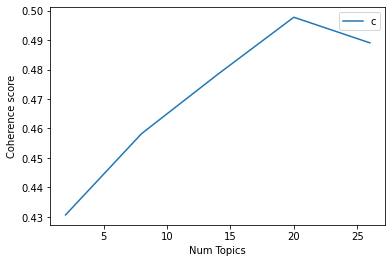

In [124]:
## Plot the curve with the values of coherence and number of topics 
# Show graph
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [125]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4307
Num Topics = 8  has Coherence Value of 0.4583
Num Topics = 14  has Coherence Value of 0.4784
Num Topics = 20  has Coherence Value of 0.4977
Num Topics = 26  has Coherence Value of 0.489


optimal topic is with 20 having coherence score of 0.49

In [126]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.213*"write" + 0.183*"article" + 0.132*"line" + 0.053*"organization" + '
  '0.025*"nntp" + 0.021*"reply" + 0.020*"opinion" + 0.014*"group" + '
  '0.013*"man" + 0.012*"number"'),
 (1,
  '0.086*"time" + 0.031*"thi" + 0.030*"day" + 0.029*"back" + 0.025*"fir" + '
  '0.023*"hear" + 0.023*"leave" + 0.017*"call" + 0.016*"end" + 0.015*"turn"'),
 (2,
  '0.023*"gun" + 0.023*"people" + 0.023*"law" + 0.022*"government" + '
  '0.010*"tate" + 0.009*"crime" + 0.009*"action" + 0.009*"weapon" + '
  '0.008*"raeli" + 0.008*"public"'),
 (3,
  '0.058*"line" + 0.048*"plea" + 0.036*"mail" + 0.026*"price" + 0.021*"offer" '
  '+ 0.018*"buy" + 0.017*"ca" + 0.016*"end" + 0.014*"email" + 0.014*"include"'),
 (4,
  '0.038*"game" + 0.036*"play" + 0.034*"team" + 0.033*"year" + 0.024*"player" '
  '+ 0.020*"win" + 0.014*"good" + 0.014*"hit" + 0.013*"run" + 0.012*"core"'),
 (5,
  '0.027*"people" + 0.015*"religion" + 0.012*"love" + 0.012*"life" + '
  '0.012*"man" + 0.011*"faith" + 0.011*"world" + 0.010*"word" + 

In [128]:
optimal_model[corpus][0]

[(0, 0.046747967479674794),
 (1, 0.061653116531165314),
 (2, 0.042682926829268296),
 (3, 0.06300813008130081),
 (4, 0.04403794037940379),
 (5, 0.03184281842818428),
 (6, 0.03726287262872629),
 (7, 0.034552845528455285),
 (8, 0.03048780487804878),
 (9, 0.048102981029810296),
 (10, 0.041327913279132794),
 (11, 0.1334688346883469),
 (12, 0.03184281842818428),
 (13, 0.034552845528455285),
 (14, 0.03319783197831978),
 (15, 0.041327913279132794),
 (16, 0.0508130081300813),
 (17, 0.0494579945799458),
 (18, 0.05758807588075881),
 (19, 0.08604336043360433)]

## Determining the topic for each sentences 

determine the topic no. with highest percentage contribution 

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



In [132]:
# Show
pd.set_option('display.max_rows',500)
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.1335,"car, bike, buy, ride, line, engine, good, driv...",From: (where my thing) Subject: WHAT car i t...
1,1,6.0,0.1409,"drive, problem, card, bit, work, driver, machi...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,3.0,0.1107,"line, plea, mail, price, offer, buy, ca, end, ...",From: (Thoma E Willi ) Subject: PB que tion ....
3,3,0.0,0.1027,"write, article, line, organization, nntp, repl...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,19.0,0.1045,"thi, thing, ome, make, find, omeone, real, ome...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,2.0,0.1841,"gun, people, law, government, tate, crime, act...",From: (Foxvog Dougla ) Subject: Re: Rewording ...
6,6,16.0,0.0726,"file, information, end, age, group, number, pr...",From: (brian manning delaney) Subject: Brain T...
7,7,6.0,0.3840,"drive, problem, card, bit, work, driver, machi...",From: (GRUBB) Subject: Re: IDE v SCSI Organiz...
8,8,14.0,0.1155,"window, image, program, application, run, work...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,6.0,0.1434,"drive, problem, card, bit, work, driver, machi...",From: (Stan Kerr) Subject: Re: Sigma De ign D...


## End of code 